## Notebook Configuration && Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from tsfresh.feature_extraction import EfficientFCParameters

from storesales.advanced_predictor import AdvancedPredictor
from storesales.light_gbm.lgb_tuner.family_lgb_params import FamilyLightGBMModelParams
from storesales.light_gbm.lgb_tuner.lgb_model_tuner import LightGBMModelTuner
from storesales.light_gbm.param_dataclasses import ExtractFeaturesParam

from storesales.light_gbm.fit_evaluate.evaluate_models import evaluate
from storesales.light_gbm.feature_engineering.ts_fresh_features import (
    make_roll,
    make_roll_features,
    get_minimal_fc_parameters,
    get_custom_minimal_fc_parameters
)
from storesales.light_gbm.dataset import make_family_datasets
from storesales.light_gbm.preprocessing import preprocess
from storesales.light_gbm.utils import (
    save_submission,
    make_submission_predictions,
    make_submission_forecast_plot,
    load_oil,
    load_stores,
    create_date_features,
)
from storesales.constants import (
    TEST_DATE_RANGE,
    VALIDATION_DATE_RANGE,
    START_SUBMISSION_DATE,
    START_VALIDATION_DATE,
    MIDDLE_TEST_DATE,
    EXTERNAL_TRAIN_PATH,
    EXTERNAL_TEST_PATH,
    EXTERNAL_OIL_PATH,
    EXTERNAL_STORES_PATH,
)

## Load && Preprocess Data

In [3]:
train_df = pd.read_csv(EXTERNAL_TRAIN_PATH, parse_dates=["date"])
test_df = pd.read_csv(EXTERNAL_TEST_PATH, parse_dates=["date"])

In [4]:
stores_df = load_stores(EXTERNAL_STORES_PATH)
oil_df = load_oil(EXTERNAL_OIL_PATH)

In [5]:
preprocessed_df = preprocess(train_df)

### Load Model && Fit && Predict

## Darts LightGBM Implementation
### Make Family Datasets

#### Prepare Data Before Making Rolling Features
1. concatenate `preprocessed_df` and `test_df` in `data_df` to get past and future values in one df;
2. fill test period sales with 0;
3. select specific `families` for LightGBM models;
4. merge `oil_df` and `stores_df` to `data_df`;
5. filter data with `threshold_timestamp` to get enough data to train LightGBM models.



In [75]:
threshold_timestamp = pd.Timestamp("2017-04-01")
# families = ["EGGS", "DAIRY", "LIQUOR,WINE,BEER", "SCHOOL AND OFFICE SUPPLIES", "PREPARED FOODS"]
families = ["MEATS", "LIQUOR,WINE,BEER"]

In [76]:
data_df = pd.concat([preprocessed_df, test_df], ignore_index=True)  # 1.

data_df.fillna(0, inplace=True)  # 2.

data_df = data_df[data_df["family"].isin(families)].copy()  # 3.

data_df = data_df.merge(oil_df, left_on="date", right_index=True, how="left")  # 4.
data_df = data_df.merge(stores_df, on="store_nbr", how="left")

min_group_date = data_df.groupby(["family", "store_nbr"])["date"].transform("min")
filtered_data_df = data_df[min_group_date <= threshold_timestamp]  # 5.

#### Rolling Features
I'll make two types of roll features: with short and long windows.   
Combined DataFrame will have features with `short` and `long` suffixes.

##### Make Rolls
* use rolls threshold timestamp to speed up feature creation and model training;
* `sales`, `onpromotion`, `dcoilwtico` are the features to roll.

In [77]:
rolls_threshold_timestamp = pd.Timestamp("2014-05-01")
# rolls_threshold_date = pd.Timestamp("2017-03-01")

rolls_data_con = filtered_data_df["date"] >= rolls_threshold_timestamp

rolls_data_df = filtered_data_df[rolls_data_con].copy()

In [78]:
features_to_roll = ["sales", "onpromotion", "dcoilwtico"]

train_rolls_short = make_roll(rolls_data_df.copy(), features_to_roll, timeshift=7)
train_rolls_long = make_roll(rolls_data_df.copy(), features_to_roll, timeshift=28)

Rolling: 100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


##### Make Features
Make short and long roll features, combine them in `train_featured_df`.

In [79]:
short_default_fc_parameters = get_custom_minimal_fc_parameters(
    number_peaks_n=[1],
    autocorrelation_lag=[1, 2],
    partial_autocorrelation_lag=[1, 2],
)
long_default_fc_parameters = get_custom_minimal_fc_parameters(
    number_peaks_n=[1, 5],
    autocorrelation_lag=[2, 5, 10],
    partial_autocorrelation_lag=[2, 5, 10],
)

extract_features_short_param = ExtractFeaturesParam(
    timeseries_container=train_rolls_short,
    default_fc_parameters=short_default_fc_parameters,
    column_sort="date",
)
extract_features_long_param = ExtractFeaturesParam(
    timeseries_container=train_rolls_long,
    default_fc_parameters=long_default_fc_parameters,
    column_sort="date",
)

In [80]:
train_featured_short = make_roll_features(extract_features_short_param, "short")
train_featured_long = make_roll_features(extract_features_long_param, "long")

Feature Extraction: 100%|██████████| 30/30 [02:33<00:00,  5.13s/it]


In [81]:
train_featured_df = pd.merge(
    train_featured_short,
    train_featured_long,
    on=["date", "store_nbr", "family"],
    how="inner",
)

In [82]:
original_data_df = data_df[["date", "family", "store_nbr", "dcoilwtico", "onpromotion"]].copy()
original_data_df.rename(columns={"dcoilwtico": "oil", "onpromotion": "promo"}, inplace=True)

train_featured_df = pd.merge(train_featured_df, original_data_df, on=["date", "family", "store_nbr"], how="left")

In [83]:
# train_featured_df.sort_values(["date", "family"], inplace=True)

#### Create Date Features
Add date features to `train_featured_df`.

In [84]:
date_features_df = create_date_features(train_featured_df, pref="date_feature_")
date_feature_cols = date_features_df.columns.to_list()

train_featured_df[date_feature_cols] = date_features_df

In [85]:
# train_featured_df.head()

#### Specify Lags

In [86]:
sales_cols = [col for col in train_featured_df.columns if "sales" in col]
onpromotion_cols = [col for col in train_featured_df.columns if "onpromotion" in col]
oil_cols = [col for col in train_featured_df.columns if "dcoilwtico" in col]

# onpromotion and oil features are future covariates
future_short_cols = [col for col in onpromotion_cols + oil_cols if "short" in col]
future_long_cols = [col for col in onpromotion_cols + oil_cols if "long" in col]

# sales features are past covariates
past_short_cols = [col for col in sales_cols if "short" in col]
past_long_cols = [col for col in sales_cols if "long" in col]

static_cols = ["city", "state", "type", "cluster"]

In [87]:
prev_season_short_lags = [-30, -33, -36, -39, -42, -365, -370, -375]
prev_season_long_lags = [-30, -38, -46, -365, -381]

lags_past_short_covariates = [-16, -18, -20] + prev_season_short_lags
lags_past_long_covariates = [-16] + prev_season_long_lags

lags_future_short_covariates = [0, -2, -4, -6, -8, -10, -12, -35, -40]
lags_future_long_covariates = [0, -30]

lags_date_feature_covariates = [0, -16, -30, -46]

sales_lags = [i for i in range(-1, -60, -1)] + [i for i in range(-365, -400, -1)]

In [88]:
# future covariates lags
date_lags = {col: lags_date_feature_covariates for col in date_feature_cols}
future_short_lags = {col: lags_future_short_covariates for col in future_short_cols}
future_long_lags = {col: lags_future_long_covariates for col in future_long_cols}

# past covariates lags
past_short_lags = {col: lags_past_short_covariates for col in past_short_cols}
past_long_lags = {col: lags_past_long_covariates for col in past_long_cols}

oil_values_lags = {"oil": [i for i in range(-1, -60, -1)] + [i for i in range(-365, -400, -1)]}
promo_values_lags = {"promo": [i for i in range(-1, -60, -1)] + [i for i in range(-365, -400, -1)]}

In [120]:
lags_future_covariates = {
    **future_short_lags, 
    **future_long_lags, 
    **date_lags, 
    **oil_values_lags, 
    **promo_values_lags
}
lags_past_covariates = {
    **past_short_lags, 
    **past_long_lags
}

#### Make Family Datasets

In [121]:
start_target_series_timestamp = rolls_threshold_timestamp - pd.Timedelta(days=10)

start_series_con = filtered_data_df["date"] > start_target_series_timestamp
# end_series_con = filtered_data_df["date"] < START_SUBMISSION_DATE

series_data = filtered_data_df[start_series_con].copy()

In [122]:
family_datasets = make_family_datasets(
    df=series_data,
    featured_df=train_featured_df,
    static_cols=static_cols,
    future_cols=list(lags_future_covariates.keys()),
    past_cols=list(lags_past_covariates.keys()),
    train_end_date=START_VALIDATION_DATE,
    start_submission_date=START_SUBMISSION_DATE,
)

In [123]:
family_datasets.keys()

dict_keys(['LIQUOR,WINE,BEER', 'MEATS'])

### Tune && Eval LightGBM Models
#### Tune Models

In [124]:
import optuna

optuna.logging.set_verbosity(optuna.logging.WARNING)

In [125]:
cat_static_covs = ["city", "state", "type", "cluster", "store_nbr"]
# cat_future_covs = date_feature_cols
cat_future_covs = []

param_suggestor = FamilyLightGBMModelParams(
    lags=sales_lags,
    lags_future_covariates=lags_future_covariates,
    lags_past_covariates=lags_past_covariates,
    categorical_static_covariates=cat_static_covs,
    categorical_future_covariates=cat_future_covs,
)

In [126]:
tuner = LightGBMModelTuner(
    family_datasets=family_datasets, families=families, param_suggestor=param_suggestor
)

In [127]:
tuner.run_parallel_tune(
    evaluate_range=VALIDATION_DATE_RANGE, n_jobs=2, eval_stride=5, n_trials=20
)

Best trial: 18. Best value: 0.235121: 100%|██████████| 20/20 [08:55<00:00, 26.77s/it]


In [128]:
best_lgb_models = tuner.fit_best(n_jobs=2)

In [130]:
best_lgb_models["LIQUOR,WINE,BEER"]

LightGBMModel(lags=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38, -39, -40, -41, -42, -43, -44, -45, -46, -47, -48, -49, -50, -51, -52, -53, -54, -55, -56, -57, -58, -59, -365, -366, -367, -368, -369, -370, -371, -372, -373, -374, -375, -376, -377, -378, -379, -380, -381, -382, -383, -384, -385, -386, -387, -388, -389, -390, -391, -392, -393, -394, -395, -396, -397, -398, -399], lags_past_covariates={'short_sales__sum_values': [-16, -18, -20, -30, -33, -36, -39, -42, -365, -370, -375], 'short_sales__median': [-16, -18, -20, -30, -33, -36, -39, -42, -365, -370, -375], 'short_sales__mean': [-16, -18, -20, -30, -33, -36, -39, -42, -365, -370, -375], 'short_sales__standard_deviation': [-16, -18, -20, -30, -33, -36, -39, -42, -365, -370, -375], 'short_sales__variance': [-16, -18, -20, -30, -33, -36, -39, -42, -365, -370, -375], 'short_sales__root_mean_square

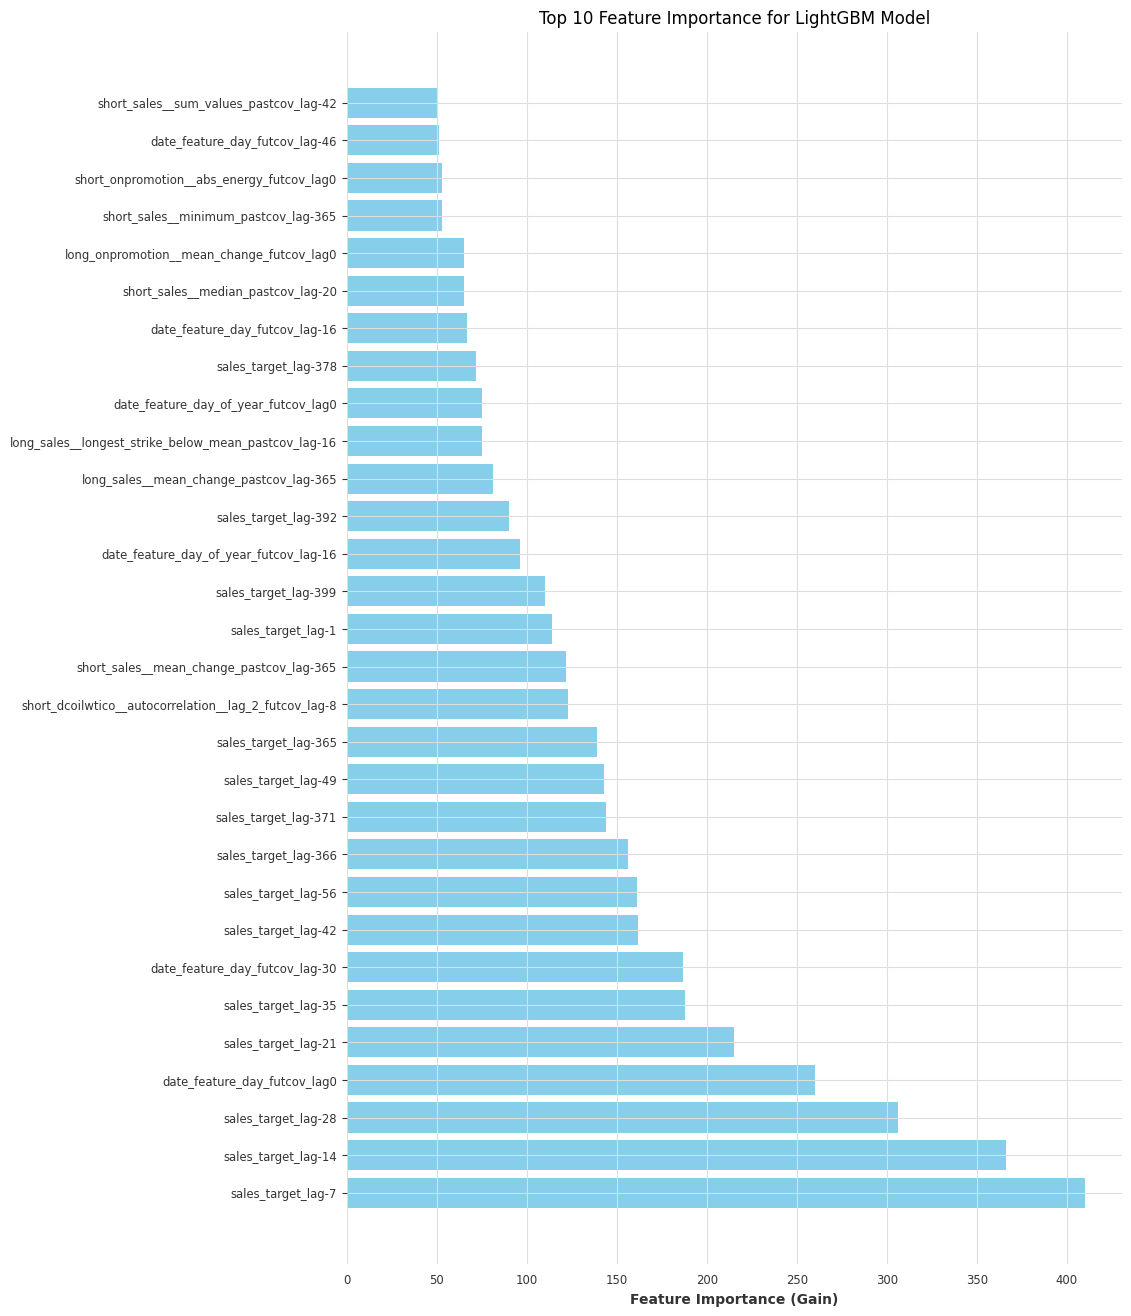

In [131]:
import matplotlib.pyplot as plt
import numpy as np

lgb_model = best_lgb_models["MEATS"] 

feature_importances = lgb_model.model.feature_importances_
feature_names = lgb_model.lagged_feature_names

top_indices = np.argsort(feature_importances)[-30:]
top_feature_importances = feature_importances[top_indices]
top_feature_names = np.array(feature_names)[top_indices]

plt.figure(figsize=(10, 16))
plt.barh(top_feature_names, top_feature_importances, color="skyblue")
plt.xlabel("Feature Importance (Gain)")
plt.title("Top 10 Feature Importance for LightGBM Model")
plt.gca().invert_yaxis()
plt.show()

#### Evaluate Models

In [132]:
eval_family_losses = evaluate(
    dataset=family_datasets,
    evaluate_range=TEST_DATE_RANGE,
    models=best_lgb_models,
    stride=1,
    parallel=True,
)

## Combine Baseline && LightGBM Models
### Prepare Baseline Data && Define Models

In [133]:
baseline_train_df = train_df.copy()
baseline_test_df = test_df.copy()

baseline_train_df.rename(columns={"date": "ds", "sales": "y"}, inplace=True)
baseline_test_df.rename(columns={"date": "ds"}, inplace=True)

In [134]:
baseline_model_file_paths = [
    "daily_predictor.pkl",
    "day_of_week_predictor.pkl",
    "weighted_day_predictor.pkl",
]
baseline_model_names = ["daily", "day_of_week", "weighted_day"]
# baseline_model_names = ["daily"]

### Make LightGBM Predictions && Create Combined Predictor

In [135]:
lightgbm_prediction_df = make_submission_predictions(family_datasets, best_lgb_models)

100%|██████████| 2/2 [00:00<00:00,  2.78it/s]


In [136]:
advanced_predictor = AdvancedPredictor(
    loss_split_date_str=MIDDLE_TEST_DATE,
    baseline_model_names=baseline_model_names,
    baseline_model_file_paths=baseline_model_file_paths,
    baseline_train_df=baseline_train_df,
    baseline_test_df=baseline_test_df,
    lightgbm_model_loss_df=eval_family_losses,
    lightgbm_model_prediction_df=lightgbm_prediction_df.reset_index(),
)

Fitting daily...


100%|██████████| 1782/1782 [00:00<00:00, 1988.70it/s]


Fitting day_of_week...


100%|██████████| 1782/1782 [00:02<00:00, 606.96it/s]


Fitting weighted_day...


100%|██████████| 1782/1782 [00:01<00:00, 1115.71it/s]


Predicting with daily...


100%|██████████| 1782/1782 [00:00<00:00, 3733.24it/s]


Predicting with day_of_week...


100%|██████████| 1782/1782 [00:00<00:00, 1966.51it/s]


Predicting with weighted_day...


100%|██████████| 1782/1782 [00:44<00:00, 39.89it/s]


In [137]:
advanced_predictor.get_min_loss()

0.35494083724913883

### Explore Loss

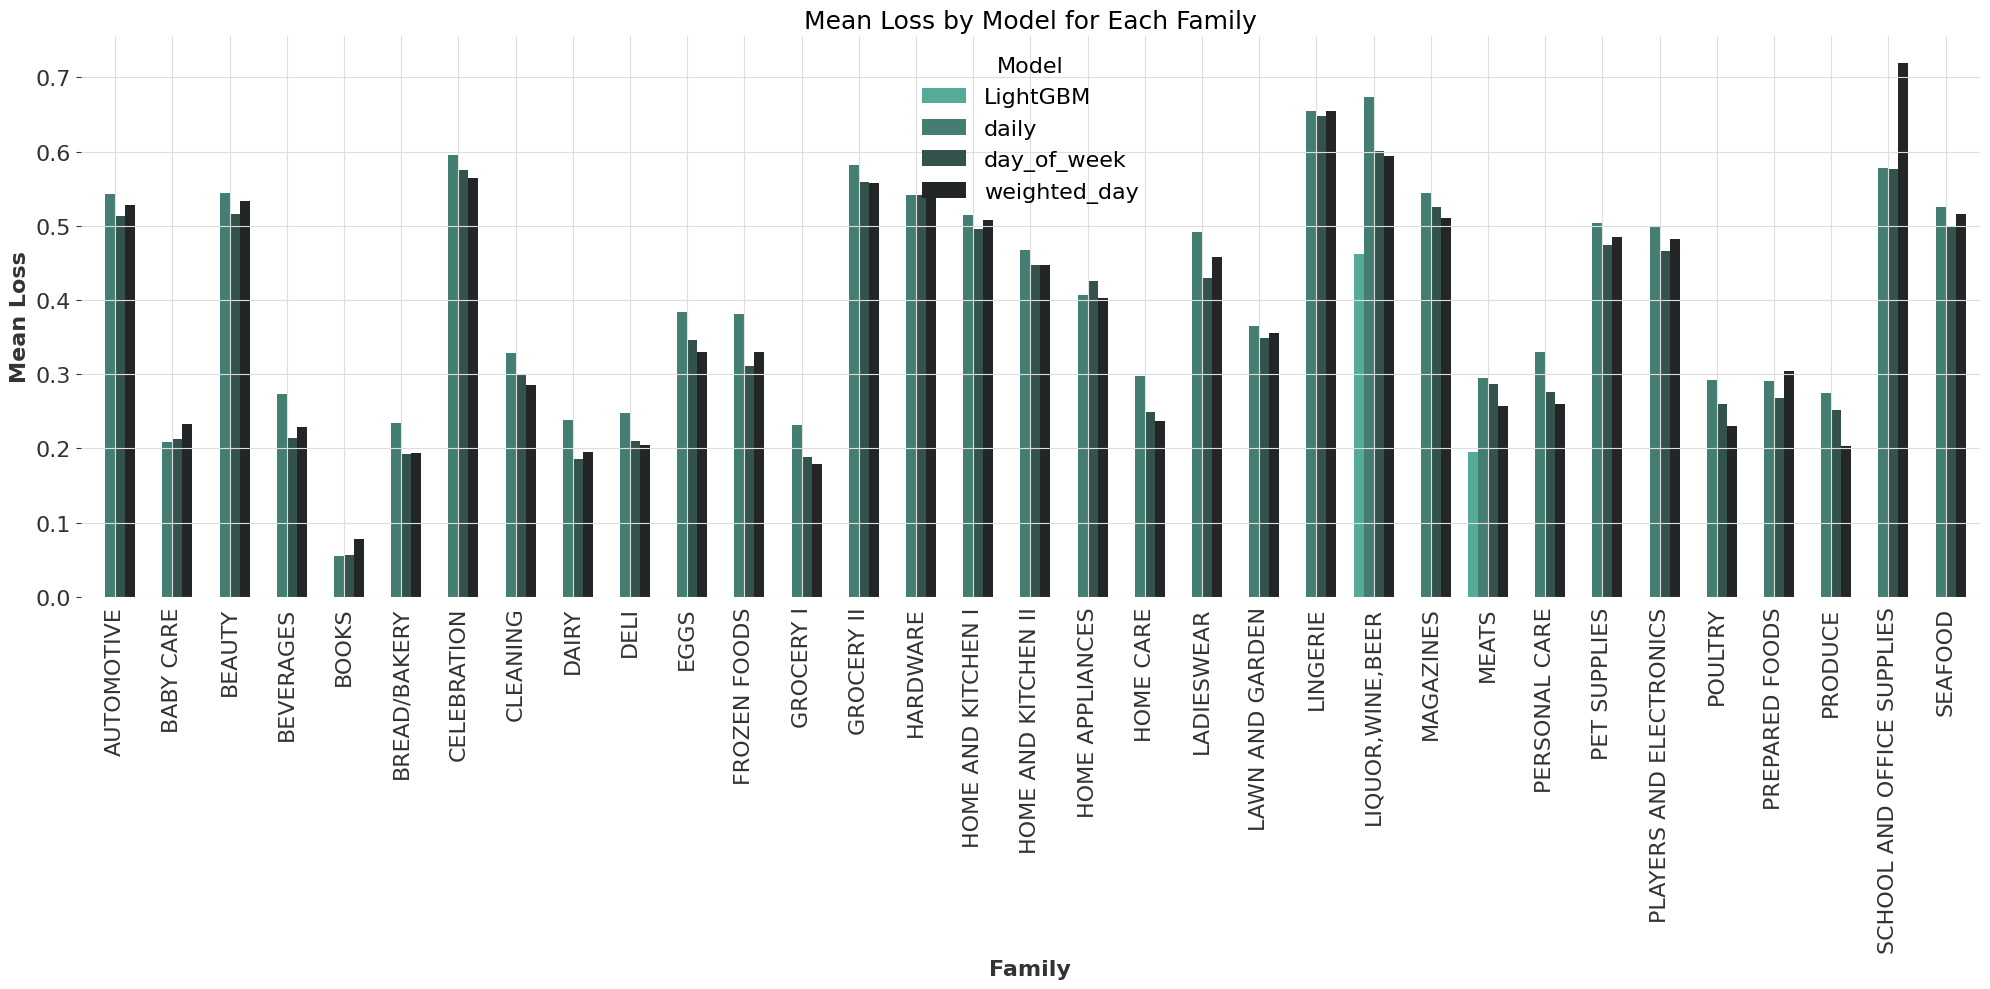

In [138]:
advanced_predictor.make_overall_family_loss_plot()

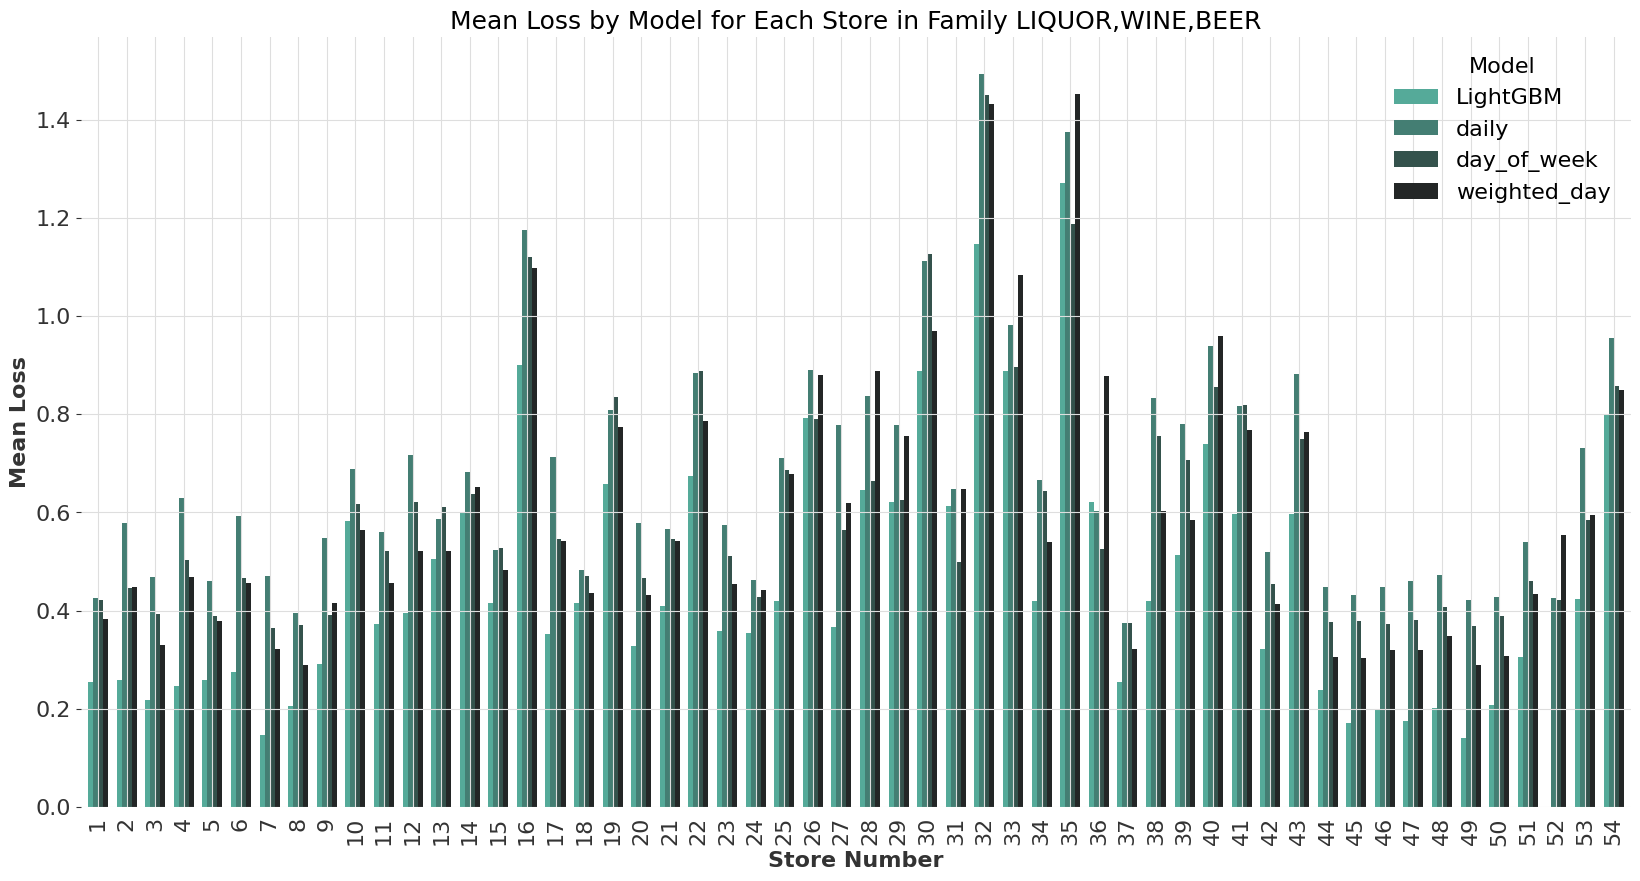

<Figure size 640x480 with 0 Axes>

In [140]:
advanced_predictor.make_family_loss_plot(family="LIQUOR,WINE,BEER")

## Save Optimal Submission

In [143]:
# lightgbm_drop_families = ["PREPARED FOODS", "SCHOOL AND OFFICE SUPPLIES"]
lightgbm_drop_families = ["LIQUOR,WINE,BEER"]
prediction_df = advanced_predictor.get_optimal_prediction(lightgbm_drop_families=lightgbm_drop_families)

In [109]:
prediction_df.reset_index()[prediction_df.reset_index()["store_nbr"] == 26]

,model,family,store_nbr,index,ds,id,onpromotion,sales
400,weighted_day,AUTOMOTIVE,26,13200,2017-08-16,3001482,0,4.531032
401,weighted_day,AUTOMOTIVE,26,13201,2017-08-17,3003264,0,2.083129
402,weighted_day,AUTOMOTIVE,26,13202,2017-08-18,3005046,0,2.949258
403,weighted_day,AUTOMOTIVE,26,13203,2017-08-19,3006828,0,3.624111
404,weighted_day,AUTOMOTIVE,26,13204,2017-08-20,3008610,0,4.14447
...,...,...,...,...,...,...,...,...
28059,day_of_week,SEAFOOD,26,13723,2017-08-27,3021116,0,4.857143
28060,day_of_week,SEAFOOD,26,13724,2017-08-28,3022898,0,1.965517
28061,day_of_week,SEAFOOD,26,13725,2017-08-29,3024680,0,1.965517
28062,day_of_week,SEAFOOD,26,13726,2017-08-30,3026462,0,1.965517


In [144]:
submission_file_name = "MEATS_tune_20_lags_more_features.csv"

submission_df = save_submission(prediction_df, submission_file_name)

Submission saved to /home/tikhon/PycharmProjects/StoreSales/data/submissions/MEATS_tune_20_lags_more_features.csv


In [113]:
submission_df.isna().sum()

sales    0
dtype: int64

### Plot Forecast

In [114]:
prediction_df.isna().sum()

index          0
ds             0
id             0
onpromotion    0
sales          0
dtype: int64

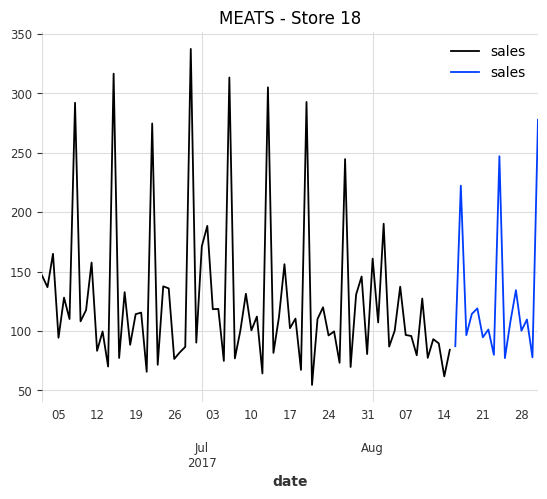

In [116]:
make_submission_forecast_plot(
    family="MEATS",
    i_series=17,
    dataset=family_datasets,
    forecast=prediction_df.reset_index(),
    drop_before_date=pd.Timestamp("2017-06-01"),
)